# CRF (и NN) для Named Entity Recognition

### Based on https://github.com/aminaghoul/NER-PyTorch

Используем conditional random fields (CRFs) для решения задачи NER и предсказания валидных последовательностей.
Например, не хотелось бы встретить `B-PER` следующий за другим `B-PER` токеном.

Будем использовать имплементацию CRF из [pytorch-crf](https://github.com/kmkurn/pytorch-crf).

In [29]:
!pip install torchtext==0.6.0 pytorch-crf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [30]:
import time
import torch
from torch import nn
from torch.optim import Adam
from torchtext.data import Field, NestedField, BucketIterator
from torchtext.datasets import SequenceTaggingDataset
from torchtext.vocab import Vocab
from collections import Counter

import torch
import torch.nn as nn
import torch.optim as optim

from torchtext import data
from torchtext import datasets

import spacy
from torchcrf import CRF

import numpy as np
import pandas as pd

import time
import random
import string
from itertools import chain

# Data preparation

In [31]:
!mkdir data_ner

mkdir: cannot create directory ‘data_ner’: File exists


In [32]:
!wget https://github.com/aminaghoul/NER-PyTorch/raw/master/data/train.csv && mv train.csv data_ner/

--2023-03-19 22:18:32--  https://github.com/aminaghoul/NER-PyTorch/raw/master/data/train.csv
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/aminaghoul/NER-PyTorch/master/data/train.csv [following]
--2023-03-19 22:18:32--  https://raw.githubusercontent.com/aminaghoul/NER-PyTorch/master/data/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1666337 (1.6M) [text/plain]
Saving to: ‘train.csv’

train.csv           100%[===================>]   1.59M  --.-KB/s    in 0.06s   

2023-03-19 22:18:32 (27.9 MB/s) - ‘train.csv’ saved [1666337/1666337]



In [33]:
!wget https://github.com/aminaghoul/NER-PyTorch/raw/master/data/valid.csv && mv valid.csv data_ner/

--2023-03-19 22:18:32--  https://github.com/aminaghoul/NER-PyTorch/raw/master/data/valid.csv
Resolving github.com (github.com)... 20.201.28.151
Connecting to github.com (github.com)|20.201.28.151|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/aminaghoul/NER-PyTorch/master/data/valid.csv [following]
--2023-03-19 22:18:33--  https://raw.githubusercontent.com/aminaghoul/NER-PyTorch/master/data/valid.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 419999 (410K) [text/plain]
Saving to: ‘valid.csv’

valid.csv           100%[===================>] 410.16K  --.-KB/s    in 0.03s   

2023-03-19 22:18:33 (11.5 MB/s) - ‘valid.csv’ saved [419999/419999]



In [34]:
!wget https://github.com/aminaghoul/NER-PyTorch/raw/master/data/test.csv && mv test.csv data_ner/

--2023-03-19 22:18:33--  https://github.com/aminaghoul/NER-PyTorch/raw/master/data/test.csv
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/aminaghoul/NER-PyTorch/master/data/test.csv [following]
--2023-03-19 22:18:33--  https://raw.githubusercontent.com/aminaghoul/NER-PyTorch/master/data/test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 378113 (369K) [text/plain]
Saving to: ‘test.csv’

test.csv            100%[===================>] 369.25K  --.-KB/s    in 0.03s   

2023-03-19 22:18:34 (10.6 MB/s) - ‘test.csv’ saved [378113/378113]



In [35]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [36]:
MIN_FREQ = 2 # слова с частотой меньше, чем MIN_FREQ, будут проигнорированы при сборке словаря
BATCH_SIZE = 16

TEXT = data.Field(lower=False) 
TAG = data.Field(unk_token=None) # Все теги известны, поэтому unk_token = None

In [37]:
my_path = "data_ner/"
train_data, valid_data, test_data = data.TabularDataset.splits(
        path=my_path ,
        train="train.csv",
        validation="valid.csv",
        test="test.csv", 
        format='csv', 
        skip_header=True,
        fields=(("text", TEXT), ("tag", TAG)),
)

In [38]:
print(train_data[4].text)
print(train_data[4].tag)

['The', 'European', 'Commission', 'said', 'on', 'Thursday', 'it', 'disagreed', 'with', 'German', 'advice', 'to', 'consumers', 'to', 'shun', 'British', 'lamb', 'until', 'scientists', 'determine', 'whether', 'mad', 'cow', 'disease', 'can', 'be', 'transmitted', 'to', 'sheep', '.']
['O', 'B-ORG', 'I-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'B-MISC', 'O', 'O', 'O', 'O', 'O', 'B-MISC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [39]:
TEXT.build_vocab(
    train_data, 
    min_freq=MIN_FREQ, 
    vectors="glove.6B.100d", # инициализировали glove-эмбеддингами
    unk_init=torch.Tensor.normal_,
)

TAG.build_vocab(train_data)

In [40]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [41]:
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size=BATCH_SIZE,
    device=device,
   sort=False,
)

TEXT_PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]  
TAG_PAD_IDX = TAG.vocab.stoi[TAG.pad_token]

# Building the model

3 основных части класса модели:

1. Подготовка слоя CRF, задание количества возможных тегов в текстах.
2. Включение слоя CRF в метод `forward()`. В методе forward() произошли серьезные изменения из-за реализации в пакете pytorch-crf. Обычно мы разделяем forward propagation и вычисление loss-функции, однако сейчас вычисление loss-функции интегрировано в `forward()`.
3. Инициализация всех невозможных переходов большим отрицательным числом (-100) в методе `init_crf_transitions`. Именно здесь мы накладываем на модель логику последовательности BIO.

In [42]:
class NNCRF(nn.Module):
    def __init__(self,
                 input_dim,
                 embedding_dim,
                 hidden_dim,
                 output_dim,
                 emb_dropout,
                 fc_dropout,
                 word_pad_idx,
                 tag_pad_idx):
        super().__init__()
        
        # LAYER 1: Word Embedding
        self.embedding_dim = embedding_dim
        self.embedding = nn.Embedding(
            num_embeddings=input_dim,
            embedding_dim=embedding_dim,
            padding_idx=word_pad_idx
        )
        self.emb_dropout = nn.Dropout(emb_dropout)

        # LAYER 2: Fully-connected  
        self.fc_dropout = nn.Dropout(fc_dropout)
        self.fc = nn.Linear(embedding_dim, hidden_dim * 2) 
        
        # LAYER 3: Fully-connected  
        self.fc_dropout2 = nn.Dropout(fc_dropout)
        self.fc2 = nn.Linear(hidden_dim * 2, output_dim) 

        # LAYER 4: CRF
        self.tag_pad_idx = tag_pad_idx
        self.crf = CRF(num_tags=output_dim)
        
        # init params with normal distribution
        for name, param in self.named_parameters():
            nn.init.normal_(param.data, mean=0, std=0.1)

    def forward(self, words, tags=None):
        # words = [sentence length, batch size]
        # chars = [batch size, sentence length, word length)
        # tags = [sentence length, batch size]
        
        # embedding_out = [sentence length, batch size, embedding dim]
        embedding_out = self.emb_dropout(self.embedding(words))

        # fc_out = [sentence length, batch size, hidden dim * 2]
        fc_out = self.fc(self.fc_dropout(embedding_out))
        
        # fc_out2 = [sentence length, batch size, output dim]
        fc_out2 = self.fc2(self.fc_dropout2(fc_out))
      
        if tags is not None:
            mask = tags != self.tag_pad_idx
            crf_out = self.crf.decode(fc_out2, mask=mask) # Поиск наиболее вероятной последовательности тегов, используя алгоритм Витерби
            crf_loss = -self.crf(fc_out2, tags=tags, mask=mask)  # Вычисляет условный log likelihood последовательности тегов с учетом emission-scores == fc_out2
        else:
            crf_out = self.crf.decode(fc_out2)
            crf_loss = None
          
        return crf_out , crf_loss

   
  
    def init_crf_transitions(self, tag_names, imp_value=-100):
        num_tags = len(tag_names)
        for i in range(num_tags):
            tag_name = tag_names[i]
            # I and <pad> cannot be in the beginning
            if tag_name[0] == "I" or tag_name == "<pad>":
                torch.nn.init.constant_(self.crf.start_transitions[i], imp_value)
        # O - I transition is impossible
        tag_is = {}
        for tag_position in ("B", "I", "O"):
            tag_is[tag_position] = [i for i, tag in enumerate(tag_names) if tag[0] == tag_position]
        impossible_transitions_position = {
            "O": "I"
        }
        for from_tag, to_tag_list in impossible_transitions_position.items():
            to_tags = list(to_tag_list)
            
            for from_tag_i in tag_is[from_tag]:
                for to_tag in to_tags:
                    for to_tag_i in tag_is[to_tag]:
                    
                        torch.nn.init.constant_(
                            self.crf.transitions[from_tag_i, to_tag_i], imp_value
                        )
        # impossible transitions between different types
        impossible_transitions_tags = {
            "B": "I",
            "I": "I"
        }
        for from_tag, to_tag_list in impossible_transitions_tags.items():
            to_tags = list(to_tag_list)
            for from_tag_i in tag_is[from_tag]:
                for to_tag in to_tags:
                    for to_tag_i in tag_is[to_tag]:
                        if tag_names[from_tag_i].split("-")[1] != tag_names[to_tag_i].split("-")[1]:
                            torch.nn.init.constant_(
                                self.crf.transitions[from_tag_i, to_tag_i], imp_value
                            )

    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

In [43]:
embedding_dim = 100
tag_pad_idx = TAG_PAD_IDX

model = NNCRF(
    input_dim=len(TEXT.vocab),
    embedding_dim=100,
    hidden_dim=256,
    output_dim=len(TAG.vocab),
    emb_dropout=0.1,
    fc_dropout=0.1,
    word_pad_idx=TEXT_PAD_IDX,
    tag_pad_idx=TAG_PAD_IDX
)

def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.normal_(param.data, mean=0, std=0.1)
        
model.apply(init_weights)

pretrained_embeddings = TEXT.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)
model.embedding.weight.data[tag_pad_idx] = torch.zeros(embedding_dim)

# инициализация переходов CRF
model.init_crf_transitions(
    tag_names=TAG.vocab.itos
)
print(f"The model has {model.count_parameters():,} trainable parameters.")

The model has 1,255,462 trainable parameters.


Мы можем получить матрицу перехода и убедиться, что инициализация выполнена так, как ожидалось:

In [44]:
def print_crf_transitions(c, m):
    tags = TAG.vocab.itos
    max_len_tag = max([len(tag) for tag in tags])
    print("Start and end tag transitions:")
    print(f"{'TAG'.ljust(max_len_tag)}\tSTART\tEND")
    for tag, start_prob, end_prob in zip(tags, m.crf.start_transitions.tolist(), m.crf.end_transitions.tolist()):
        print(f"{tag.ljust(max_len_tag)}\t{round(start_prob, 2)}\t{round(end_prob, 2)}")
    print()
    print("Between tags transitions:")
    persons_i = [i for i, tag in enumerate(TAG.vocab.itos) if "PER" in tag or tag == "O"]
    max_len_tag = max([len(tag) for tag in TAG.vocab.itos if "PER" in tag ])
    transitions = m.crf.transitions
    to_tags = "TO".rjust(max_len_tag) + "\t" + "\t".join([tag.ljust(max_len_tag) for tag in tags if "PER" in tag or tag == "O"])
    print(to_tags)
    print("FROM")
    for from_tag_i, from_tag_probs in enumerate(transitions[persons_i]):
        to_tag_str = f"{tags[persons_i[from_tag_i]].ljust(max_len_tag)}"
        for to_tag_prob in from_tag_probs[persons_i]:
            to_tag_str += f"\t{str(round(to_tag_prob.item(), 2)).ljust(max_len_tag)}"
        print(to_tag_str)

print_crf_transitions(TEXT, model)

Start and end tag transitions:
TAG   	START	END
<pad> 	-100.0	0.01
O     	-0.06	0.07
B-LOC 	0.1	-0.01
B-PER 	0.04	0.07
B-ORG 	0.03	0.16
I-PER 	-100.0	0.04
I-ORG 	-100.0	0.14
B-MISC	0.02	-0.0
I-LOC 	-100.0	-0.09
I-MISC	-100.0	0.05

Between tags transitions:
   TO	O    	B-PER	I-PER
FROM
O    	0.11 	0.13 	-100.0
B-PER	0.1  	0.01 	0.07 
I-PER	0.07 	-0.15	-0.07


# Training

Выходами модели являются два списка: прогнозы и значения loss'а

In [52]:
def opt(model, lr=1e-5, eps=1e-6, weight_decay_rate=0.001, second_weight_decay_rate=0.0):
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
            'weight_decay_rate': weight_decay_rate},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
            'weight_decay_rate': second_weight_decay_rate}]
    return optim.Adam(
        optimizer_grouped_parameters,
        lr=lr,
        eps=eps,
    )

optimizer = opt(model, lr=1e-5, eps=1e-6, weight_decay_rate=0.001, second_weight_decay_rate=0.0)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
criterion = nn.CrossEntropyLoss(ignore_index=TAG_PAD_IDX)
model = model.to(device)

 - Metrics

In [46]:
from sklearn.metrics import f1_score, classification_report

def f1_loss( preds, y, tag_pad_idx, full_report=False):
    index_o = TAG.vocab.stoi["O"]
    positive_labels = [i for i in range(len(TAG.vocab.itos))
                       if i not in (tag_pad_idx, index_o)]

    flatten_preds = [pred for sent_pred in preds for pred in sent_pred]

    positive_preds = [pred for pred in flatten_preds
                      if pred not in (tag_pad_idx, index_o)]

    flatten_y = [tag for sent_tag in y for tag in sent_tag]
    if full_report:
      
        positive_names = [TAG.vocab.itos[i]
                              for i in range(len(TAG.vocab.itos))
                              if i not in (tag_pad_idx, index_o)]
        print(classification_report(
                y_true=flatten_y,
                y_pred=flatten_preds,
                labels=positive_labels,
                target_names=positive_names
            ))

    return f1_score(
            y_true=flatten_y,
            y_pred=flatten_preds,
            labels=positive_labels,
            average="micro"
        ), flatten_preds, flatten_y

In [47]:
def train(model, iterator, optimizer, tag_pad_idx):
    epoch_loss = 0
    epoch_f1 = 0    
    model.train()
    
    for batch in iterator:
        
        text = batch.text
        tags = batch.tag
      
        optimizer.zero_grad()

        pred_tags_list, batch_loss = model(text, tags)
        
        # to calculate loss and F1 score we flatten true tags
        true_tags_list = [
                [tag for tag in sent_tag if tag != TAG_PAD_IDX]
                for sent_tag in tags.permute(1, 0).tolist()
            ]
        f1, _, _ = f1_loss(pred_tags_list, true_tags_list, tag_pad_idx)

        batch_loss.backward()
        
        optimizer.step()
        epoch_loss += batch_loss.item()
        epoch_f1 += f1
        
    return epoch_loss / len(iterator), epoch_f1 / len(iterator)

In [48]:
def evaluate(model, iterator, tag_pad_idx,full_report):
    epoch_loss = 0
    epoch_f1 = 0
    
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
    
        for batch in iterator:

            text = batch.text
            tags = batch.tag
        
            pred_tags_list, batch_loss = model(text, tags)
            true_tags_list = [
                [tag for tag in sent_tag if tag != TAG_PAD_IDX]
                for sent_tag in tags.permute(1, 0).tolist()
                ]
            
            f1, pred, lab = f1_loss(pred_tags_list, true_tags_list, tag_pad_idx, full_report)
            preds.append(pred)
            labels.append(lab)
            epoch_loss += batch_loss.item()
            epoch_f1 += f1
        
    return epoch_loss / len(iterator), epoch_f1 / len(iterator),preds, labels

In [51]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

N_EPOCHS = 15

In [53]:
t_loss = []
t_f1 = []
v_loss = []
v_f1 = []

best_valid_loss = float('inf')
for epoch in range(N_EPOCHS):
    start_time = time.time()
   
    train_loss, train_f1 = train(model, train_iterator, optimizer, TAG_PAD_IDX)
    t_loss.append(train_loss)
    t_f1.append(train_f1) 
    
    valid_loss, valid_f1,_,_ = evaluate(model, valid_iterator, TAG_PAD_IDX, full_report= False)
    v_loss.append(valid_loss)
    v_f1.append(valid_f1)
    
    scheduler.step()
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut3-model_conll.pt')
    

    if epoch % 1 == 0: 
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train F1 score: {train_f1*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. F1 score: {valid_f1*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 46s
	Train Loss: 128.683 | Train F1 score: 15.51%
	 Val. Loss: 112.571 |  Val. F1 score: 15.80%
Epoch: 02 | Epoch Time: 0m 48s
	Train Loss: 115.738 | Train F1 score: 16.95%
	 Val. Loss: 104.181 |  Val. F1 score: 17.20%
Epoch: 03 | Epoch Time: 0m 48s
	Train Loss: 108.008 | Train F1 score: 18.47%
	 Val. Loss: 99.049 |  Val. F1 score: 18.57%
Epoch: 04 | Epoch Time: 0m 47s
	Train Loss: 103.417 | Train F1 score: 19.16%
	 Val. Loss: 95.205 |  Val. F1 score: 18.60%
Epoch: 05 | Epoch Time: 0m 48s
	Train Loss: 100.346 | Train F1 score: 19.85%
	 Val. Loss: 92.180 |  Val. F1 score: 19.27%
Epoch: 06 | Epoch Time: 0m 48s
	Train Loss: 97.264 | Train F1 score: 21.02%
	 Val. Loss: 89.827 |  Val. F1 score: 20.45%
Epoch: 07 | Epoch Time: 0m 47s
	Train Loss: 95.185 | Train F1 score: 21.59%
	 Val. Loss: 87.813 |  Val. F1 score: 21.58%
Epoch: 08 | Epoch Time: 0m 48s
	Train Loss: 93.205 | Train F1 score: 22.40%
	 Val. Loss: 86.081 |  Val. F1 score: 23.39%
Epoch: 09 | Epoch Time: 0

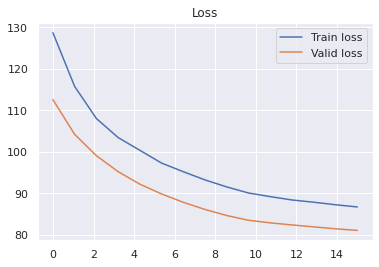

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np 

sns.set()

x = np.linspace(0, N_EPOCHS,N_EPOCHS)

plt.plot(x,t_loss)
plt.plot(x,v_loss)
plt.title("Loss")
plt.legend(["Train loss", "Valid loss"])

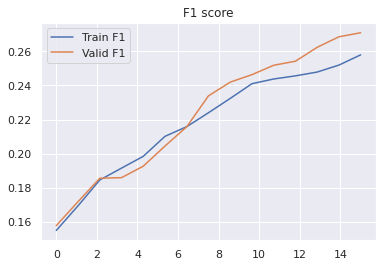

In [55]:
x = np.linspace(0, N_EPOCHS, N_EPOCHS)

plt.plot(x,t_f1)
plt.plot(x,v_f1)
plt.title("F1 score")
plt.legend(["Train F1", "Valid F1"])

In [56]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
model.load_state_dict(torch.load('tut3-model_conll.pt'))

test_loss, test_f1, preds, labels = evaluate(model, test_iterator, TAG_PAD_IDX, full_report=False)
print(f'Test Loss: {test_loss:.3f} |  Test F1 score: {test_f1*100:.2f}%')

Test Loss: 73.808 |  Test F1 score: 23.41%


In [57]:
predict =  [item for sublist in preds for item in sublist]
true =  [item for sublist in labels for item in sublist]
confusion = confusion_matrix(true, predict)

### Confusion matrix

In [59]:
TAG.vocab.itos

['<pad>',
 'O',
 'B-LOC',
 'B-PER',
 'B-ORG',
 'I-PER',
 'I-ORG',
 'B-MISC',
 'I-LOC',
 'I-MISC']

In [63]:
confusion_df = pd.DataFrame(confusion)

confusion_df.columns = [i for i in TAG.vocab.itos if i != '<pad>']
s = pd.Series([i for i in TAG.vocab.itos if i != '<pad>'])
confusion_df = confusion_df.set_index([s])

confusion_df['LOC'] = confusion_df['B-LOC'] + confusion_df['I-LOC']
confusion_df['PER'] = confusion_df['B-PER'] + confusion_df['I-PER']
confusion_df['ORG'] = confusion_df['B-ORG'] + confusion_df['I-ORG']
confusion_df['MISC'] = confusion_df['B-MISC'] + confusion_df['I-MISC']


#confusion_df = confusion_df.drop(columns=[ i for i in TAG.vocab.itos if i != 'O'])

confusion_df.loc['LOC'] = confusion_df.loc['B-LOC'] + confusion_df.loc['I-LOC']
confusion_df.loc['PER'] = confusion_df.loc['B-PER'] + confusion_df.loc['I-PER']
confusion_df.loc['ORG'] = confusion_df.loc['B-ORG'] + confusion_df.loc['I-ORG']
confusion_df.loc['MISC'] = confusion_df.loc['B-MISC'] + confusion_df.loc['I-MISC']

#confusion_df = confusion_df.drop([i for i in TAG.vocab.itos if i != 'O'])

confusion_df

,O,B-LOC,B-PER,B-ORG,I-PER,I-ORG,B-MISC,I-LOC,I-MISC,LOC,PER,ORG,MISC
O,37405,77,252,64,581,69,36,6,30,83,833,133,66
B-LOC,1011,507,71,23,35,9,7,1,3,508,106,32,10
B-PER,1170,53,183,28,134,33,10,4,1,57,317,61,11
B-ORG,1158,174,139,139,26,4,19,0,1,174,165,143,20
I-PER,762,8,4,3,307,59,4,6,3,14,311,62,7
I-ORG,443,11,18,12,167,142,1,33,7,44,185,154,8
B-MISC,422,22,74,13,21,6,141,0,2,22,95,19,143
I-LOC,129,5,5,0,21,18,0,78,1,83,26,18,1
I-MISC,90,3,3,1,29,11,4,1,72,4,32,12,76
LOC,1140,512,76,23,56,27,7,79,4,591,132,50,11


### Precision-Recall-F1Score

In [64]:
cm = confusion_df.to_numpy()

TP = np.diag(cm)
FP = np.sum(cm, axis=0) - TP
FN = np.sum(cm, axis=1) - TP

num_classes = 4
TN = []
for i in range(num_classes):
    temp = np.delete(cm, i, 0)    
    temp = np.delete(temp, i, 1) 
    TN.append(sum(sum(temp)))
    
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1 = (2 * precision * recall) / (precision + recall)

prf_df = pd.DataFrame()
prf_df['Precision'] = precision
prf_df['Recall'] = recall
prf_df['F1-score'] = f1

s = pd.Series([i for i in confusion_df.index])
prf_df = prf_df.set_index([s])

prf_df

,Precision,Recall,F1-score
O,0.782941,0.943737,0.855852
B-LOC,0.308582,0.218252,0.255673
B-PER,0.146870,0.088749,0.110641
B-ORG,0.276892,0.064292,0.104354
I-PER,0.148957,0.198065,0.170036
I-ORG,0.224329,0.115918,0.152853
B-MISC,0.345588,0.143878,0.203170
I-LOC,0.309524,0.202597,0.244898
I-MISC,0.342857,0.213018,0.262774
LOC,0.311873,0.218242,0.256789


## Inference

In [65]:
def tag_sentence(model, device, sentence, text_field, tag_field):
    model.eval()
    
    if isinstance(sentence, str):
        nlp = spacy.load('en_core_web_sm')
        tokens = [token.text for token in nlp(sentence)]
    else:
        tokens = [token for token in sentence]

    if text_field.lower:
        tokens = [t.lower() for t in tokens]
        
    max_word_len = max([len(token) for token in tokens])

    numericalized_tokens = [text_field.vocab.stoi[t] for t in tokens]
    unk_idx = text_field.vocab.stoi[text_field.unk_token]  
    unks = [t for t, n in zip(tokens, numericalized_tokens) if n == unk_idx]
    
    token_tensor = torch.as_tensor(numericalized_tokens)    
    token_tensor = token_tensor.unsqueeze(-1).to(device)

    predictions, _ = model(token_tensor)
    predicted_tags = [tag_field.vocab.itos[t] for t in predictions[0]]
    
    return tokens, predicted_tags, unks

In [66]:
example_index = 6

sentence = vars(valid_data.examples[example_index])['text']
actual_tags = vars(valid_data.examples[example_index])['tag']

print(sentence)
print(actual_tags)

['Trailing', 'by', '213', ',', 'Somerset', 'got', 'a', 'solid', 'start', 'to', 'their', 'second', 'innings', 'before', 'Simmons', 'stepped', 'in', 'to', 'bundle', 'them', 'out', 'for', '174', '.']
['O', 'O', 'O', 'O', 'B-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [67]:
tokens, pred_tags, unks = tag_sentence(model, device, sentence, TEXT, TAG)
print(pred_tags)
print(actual_tags)

['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['O', 'O', 'O', 'O', 'B-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


/usr/local/lib/python3.9/dist-packages/torchcrf/__init__.py:305: UserWarning: where received a uint8 condition tensor. This behavior is deprecated and will be removed in a future version of PyTorch. Use a boolean condition instead. (Triggered internally at ../aten/src/ATen/native/TensorCompare.cpp:413.)
  score = torch.where(mask[i].unsqueeze(1), next_score, score)


In [68]:
print("Pred. Tag\t\t\t\tActual Tag\t\t\t\tCorrect?\t\t\t\tToken\n")

for token, pred_tag, actual_tag in zip(tokens, pred_tags, actual_tags):
    correct = '✔' if pred_tag == actual_tag else '✘'
    space = 5 if pred_tag == 'O'else 4
    space1 = 5 if actual_tag == 'O'else 4   
    print(pred_tag,"\t"*space, actual_tag, "\t"*space1, correct,"\t"*5, token)

Pred. Tag				Actual Tag				Correct?				Token

O 					 O 					 ✔ 					 Trailing
O 					 O 					 ✔ 					 by
O 					 O 					 ✔ 					 213
O 					 O 					 ✔ 					 ,
O 					 B-ORG 				 ✘ 					 Somerset
O 					 O 					 ✔ 					 got
O 					 O 					 ✔ 					 a
O 					 O 					 ✔ 					 solid
O 					 O 					 ✔ 					 start
O 					 O 					 ✔ 					 to
O 					 O 					 ✔ 					 their
O 					 O 					 ✔ 					 second
O 					 O 					 ✔ 					 innings
O 					 O 					 ✔ 					 before
B-LOC 				 B-PER 				 ✘ 					 Simmons
O 					 O 					 ✔ 					 stepped
O 					 O 					 ✔ 					 in
O 					 O 					 ✔ 					 to
O 					 O 					 ✔ 					 bundle
O 					 O 					 ✔ 					 them
O 					 O 					 ✔ 					 out
O 					 O 					 ✔ 					 for
O 					 O 					 ✔ 					 174
O 					 O 					 ✔ 					 .
